# Polynomial Regression and Classification

So far, all we know is how to fit our data to lines using linear regression and logistic curves using logistic regression.  It turns out that with a little bit of work, we can generalize these two models to fit most situations.  There are two directions in which our functions can grow: the can grow _dimensionally_, or they can grow _flexibly_.

### Multidimensional Linear Regression

Suppose we have a dataset consisting of two numerical features and a numerical response.

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # needed for 3d plotting
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import load_iris

%matplotlib inline

def add_noise(y, intensity = 1.0):
    """ Add noise to a vector. """
    return y + intensity*np.random.randn(y.shape[0])

In [69]:
df = pd.DataFrame({'x1':[1,2,4,3,6,1,2], 'x2':[0.5,3,1,1,2,4,5], 'y': [4,12,10.5,8.5,17,14,19.5]})
df

,x1,x2,y
0,1,0.5,4.0
1,2,3.0,12.0
2,4,1.0,10.5
3,3,1.0,8.5
4,6,2.0,17.0
5,1,4.0,14.0
6,2,5.0,19.5


In that case, my goal is to create a function $f(x_1, x_2) = \widehat{y}$, and if I simply extend the model from linear regression, I am trying to create a two-dimensional linear function:

$$f(x_1, x_2) = m_1 \cdot x_1 + m_2 \cdot x_2 + b$$

This is the equation of a plane.  Here, I'll use Scikit-Learn's linear regression model to fit my data.  It works just as it does with a one-dimensional collection of features!

In [66]:
model = LinearRegression()
model.fit(df[['x1', 'x2']], df['y'])

print("Model coefficients: " + str(model.coef_))
print("Model intercept: " + str(model.intercept_))

Model coefficients: [ 1.76847575  3.01385681]
Model intercept: 0.310046189376


How do I graph this?  In practice, you mostly don't.  It's not super helpful to graph it.  One thing you _could_ do is plot, say, $x_1$ against $y$, and fill in the value for $x_2$ on the mean, and conversely for $x_2$ and $x_1$.

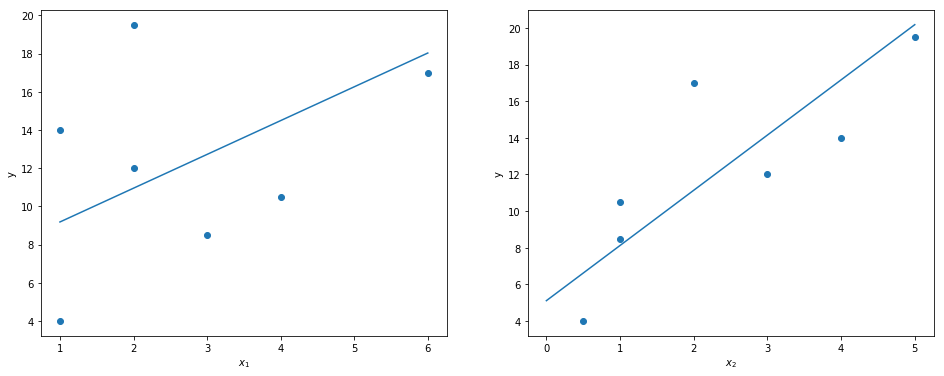

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
m_1, m_2 = model.coef_
b = model.intercept_
ax[0].scatter(df['x1'], df['y'])
ax[0].plot([1, 6], [m_1 * 1 + m_2 * df['x2'].mean() + b, m_1 * 6 + m_2 * df['x2'].mean() + b])
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('y')

ax[1].scatter(df['x2'], df['y'])
ax[1].plot([0, 5], [0 + m_1 *  df['x1'].mean() + b, m_2 * 5 + m_1 * df['x1'].mean() + b])
ax[1].set_xlabel('$x_2$')
ax[1].set_ylabel('y')

This is two slices of the _plane_ that you fit to your data.  More generally, if you have $m$ features, then you will fit an $m$-dimensional "line" to your data: each feature $x_i$ gets a parameter $m_i$, and there's one intercept.  This is usually called an _$m$-dimensional hyperplane_. 

### Multidimensional Logistic Regression
This is extremely similar.  Here, you're fitting: 
$$f(x_1, x_2) = \dfrac{1}{1 + e^{(m_1 \cdot x_1 + m_2 \cdot x_2 + b)}}.$$

One nice example of this is when you are doing two-dimensional classification, and you want to visualize your _decision boundary_.  Let's load a dataset and restrict to this case.

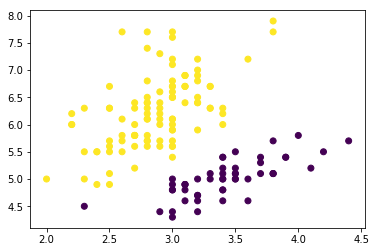

In [70]:
# Good ol' iris
d = load_iris()
df = pd.DataFrame(d.data, columns=d.feature_names)
cols = ['sepal width (cm)', 'sepal length (cm)']
df = df[cols]
df['species'] = pd.Series(d.target).map(lambda x: 0 if x == 0 else 1)

plt.scatter(df[cols[0]], df[cols[1]], c=df['species'])
plt.show()

Let's fit a two-dimensional logistic regression, and plot the 50%-line, _i.e._ the decision boundary.

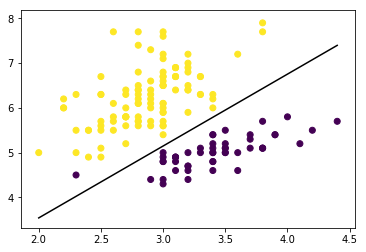

In [71]:
model = LogisticRegression()
model.fit(df[cols], df['species'])

# This is particular to the fact that the decision boundary is a line!
w = model.coef_[0]
a = -w[0] / w[1]
xx = np.arange(2.0, 4.5, 0.1)
yy = a * xx - (model.intercept_[0]) / w[1]

plt.plot(xx, yy, 'k-')
plt.scatter(df[cols[0]], df[cols[1]], c=df['species'])
plt.show()

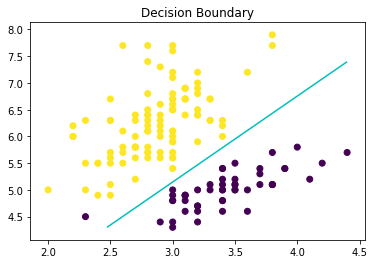

In [107]:
# Let's recreate this same plot but with code that will work for a possibly-curved decision boundary.
### This is for your copying purposes... it's okay if this code is foreign to you.

def scatter_with_decision(original_x, original_y, original_z, model, rules=None):
    """ Create a scatter plot for 2-dimensional input data, as well as the decision 
    boundary for the given logistic regression model. 
    
    parameters:
        original_x, original_y, original_z: numpy arrays
            the data for the two input dimensions (x and y) and output (z, with values 0 or 1)
        model: sklearn.linear_model.LogisticRegression
            the already-fit model
        rules: List[(index, function)]
            A collection of functions defining how to turn the original 
            columns into your engineered columns.  The index is either `0` or `1` 
            to indicate that the rule is applied to column 0 or 1, or `2` if 
            the rule uses both columns.
            Some examples:
                if you want `original_x**2`, your `rules` should contain the tuple `(0, lambda x: x**2)`.  
                if you want `original_y**3`, your `rules` should contain the tuple `(1, lambda x: x**3)`.
                if you want `original_x * original_y`, your `rules` should contain the tuple `(2, lambda x, y: x*y)`.
    returns:
        the Figure and Axes objects produced (in order to add more to it if you want, 
            e.g. title and axis labels)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ### create the decision surface
    x = np.arange(original_x.min(), original_x.max(), 0.1)
    y = np.arange(original_y.min(), original_y.max(), 0.1)
    xx, yy = np.meshgrid(x, y)                       # this is its xy-coordinate grid

    ### We need to "ravel" the grid's matrices to make them one long column
    grid_as_columns =[xx.ravel(), yy.ravel()]
    if rules:
        for i, rule in rules:
            if i < 2:
                # this rule uses only one input column
                grid_as_columns.append(rule(grid_as_columns[i]))    
            else:
                # this rule uses both input columns
                grid_as_columns.append(rule(grid_as_columns[0], grid_as_columns[1]))
    dataset_cols = np.array(grid_as_columns).T       # now we have all the points in the grid as a long (_)x2 array 

    ### Now we can feed them into the prediction function and reshape it back to the grid
    zz_col = model.predict_proba(dataset_cols).T[0]
    zz = zz_col.reshape(xx.shape)                    # finally, we have the z-coordinates for each grid point

    # make the plots
    ax.contour(xx, yy, zz, levels=[.5], colors=['c'])
    ax.scatter(original_x, original_y, c=original_z)
    return fig, ax
    
fig, ax = scatter_with_decision(df[cols[0]], df[cols[1]], df['species'], model)
ax.set_title("Decision Boundary");

What you want to imagine here is that we have fit a two-dimensional function to this data, where the yellow points are all situated at $(x, y, 1)$ and the purple points are all situated at $(x, y, 0)$, and the function is a sheet with heights between 0 and 1.  The line is where the sheet hits the $0.5$ line.

Together, these ideas (and scikit-learn classes) give us the ability to fit data of any dimensionality. However, we're still fitting very rigid models in these dimensions.  Time for another trick!

### Polynomial Regression

Imagine I have the following dataset:

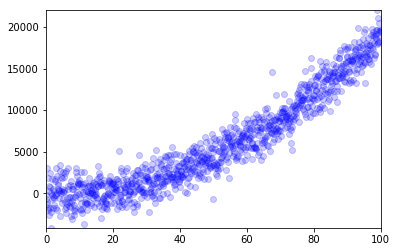

In [7]:
# First we create data
x = np.arange(0,100,.1)
par = {'a':2, 'b':-12, 'c':-3} # parabola!
y_p = add_noise(np.array([
                par['a'] * i**2 + par['b'] * i + par['c']  
                for i in x]), 
              intensity=1500)

# Create a Figure object in which my plot will reside
fig = plt.figure()
polydata_graph = fig.add_subplot(1,1,1)

# Create a "subplot"
polydata_graph.scatter(x, y_p, c='b', alpha=0.2)
polydata_graph.axis([0,100,y_p.min(),y_p.max()])

plt.show()

I can attempt to fit this with a line, and then side-by-side plot the __residual plot__, that is the plot of $x_i$ versus $\widehat{y}_i - y_i$.  The residual plot is a very important thing to look at, because if you aren't seeing random noise, then that's an indicator that you haven't found a good model.

In [8]:
# Construct a regression model
linreg = LinearRegression()
linreg.fit(x.reshape(-1,1),y_p)

m_poly = linreg.coef_[0]
b_poly = linreg.intercept_
print("Slope:", m_poly, "Intercept:", b_poly)

Slope: 191.222517545 Intercept: -3491.90389227


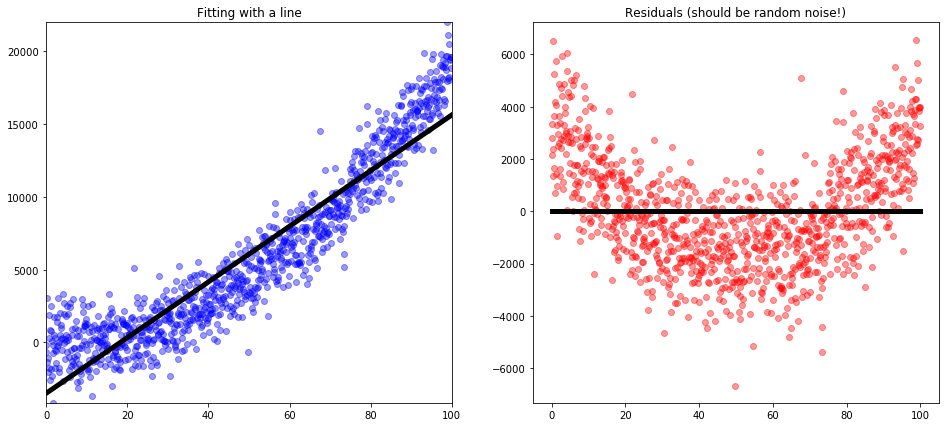

In [9]:
# Create a Figure and subplot objects
fig = plt.figure(figsize=(16,7))
polydata_graph = fig.add_subplot(1,2,1)
residuals = fig.add_subplot(1,2,2)

# Plot the data and the best fit line
polydata_graph.scatter(x, y_p, c='b', alpha=0.4)
polydata_graph.axis([0,100,y_p.min(),y_p.max()])
polydata_graph.plot([0,100],[b_poly, b_poly + 100 * m_poly], c='k', linewidth=5)
polydata_graph.set_title("Fitting with a line")

# Create residuals array
resid = y_p - np.array([b_poly + i * m_poly for i in x])

# Plot the residuals
residuals.scatter(x, resid, c='r', alpha=0.4)
residuals.plot([0,100],[0,0], c='k', linewidth=5)
# residuals.plot()
residuals.set_title("Residuals (should be random noise!)")

plt.show()

In statistical lingo, what we see here is that there is correlation between the residuals and $x$. If you go to a certain $x$ value, you have a better-than-$50\%$ chance of guessing whether the residual there is positive or negative.  There's also autocorrelation with the residuals: if you know where one residual is, you have a better-than-$50\%$ chance of guessing where its neighbors are. The take away is:

### You have not fit the data with your model!

You may wish to ask "but how could we possibly fit a line to polynomial data?"  The key is to _construct a new feature from the old one(s)_.

In [10]:
df = pd.DataFrame(x, columns = ['x'])
print(df.shape, " <-- See, 1-dimensional!")

df.head(5)

(1000, 1)  <-- See, 1-dimensional!


,x
0,0.0
1,0.1
2,0.2
3,0.3
4,0.4


Since we can look at the picture and it looks like a parabola, we want to create a new axis, call it $w$.  For its data, we will set $w = x^2$. Normally, figuring out what to make it is tough.  You may need to make some crazy function of multiple previous columns.

In [11]:
df['w (or rather, x^2)'] = df['x']**2
df.head()

,x,"w (or rather, x^2)"
0,0.0,0.00
1,0.1,0.01
2,0.2,0.04
3,0.3,0.09
4,0.4,0.16


In order to see what we're doing graphically, we need some more magic.

### New Jupyter Magic

This "Jupyter magic" will still create plots inline with the notebook, but it will give the plots some very basic interactivity.  I typically only use it if I will need it, because it tends to get in my way when scrolling around the notebook or changing plots.  It somewhat messes with the plots when you use the "shorthand way" of constructing plots 

In [ ]:
# Note: after running this cell, you'll be in "Notebook mode" 
# until you run the top cell again.  Don't forget about kernel
# linearity!

%matplotlib notebook

The visuals were hanging my computer for some reason, so I downsample the x's, w's, and y's:

In [12]:
down_df = df[::10]
down_y_p = y_p[::10]

print(down_df.shape, down_y_p.shape)
down_df.head()

(100, 2) (100,)


,x,"w (or rather, x^2)"
0,0.0,0.0
10,1.0,1.0
20,2.0,4.0
30,3.0,9.0
40,4.0,16.0


Now take a look at what we've created with this new dataset:

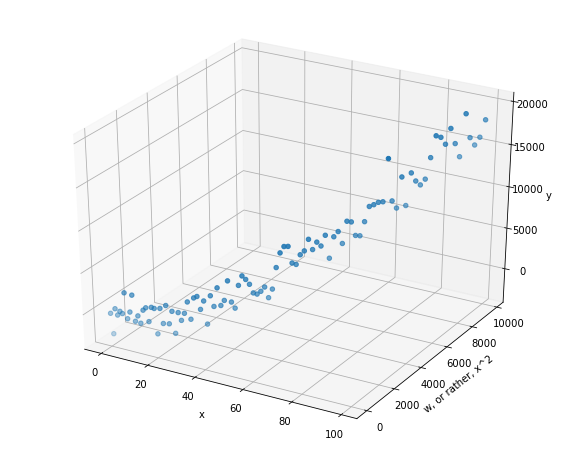

In [13]:
fig = plt.figure(figsize=(10,8))
scatter_3d = fig.add_subplot(111, projection='3d')

scatter_3d.scatter(down_df['x'], down_df['w (or rather, x^2)'], down_y_p)

scatter_3d.set_xlabel('x')
scatter_3d.set_ylabel('w, or rather, x^2')
scatter_3d.set_zlabel('y')

Now, we fit a plane to this dataset:

In [15]:
planereg = LinearRegression()
planereg.fit(df.values, y_p) #df.values is the numpy array underlying the pandas dataframe

# model parameters
m_x, m_w = planereg.coef_
b = planereg.intercept_
print("x-coefficient:", m_x, ", w-coefficient:", m_w, ", intercept: ", b)

x-coefficient: -12.6706136878 , w-coefficient: 2.04097228461 , intercept:  -100.481476096


Next, we plot the plane we've fit:

In [16]:
# Generate a mesh
x_plane = np.arange(0, 100, 1)                
w_plane = np.arange(0, 10000, 100)
x_plane, w_plane = np.meshgrid(x_plane, w_plane)

# Construct the plane's y-values
y_plane = m_x * x_plane + m_w * w_plane + b

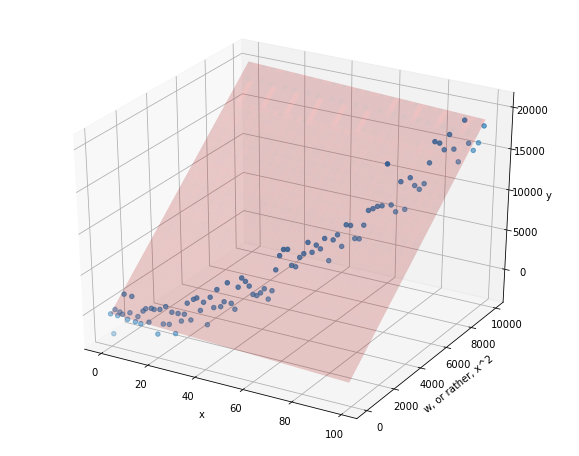

In [17]:
fig = plt.figure(figsize=(10,8))
scatter_3d = fig.add_subplot(1,1,1, projection='3d')

scatter_3d.set_xlabel('x')
scatter_3d.set_ylabel('w, or rather, x^2')
scatter_3d.set_zlabel('y')

# Plot the data
scatter_3d.scatter(down_df['x'], down_df['w (or rather, x^2)'], down_y_p)

# Plot the plane
scatter_3d.plot_surface(x_plane, w_plane, y_plane, color='r', alpha=.2)

plt.show()

Amazing!  We did fit a "line" of _some_ dimension to the data.  To finish off, we just "remember" that $w$ is really $x^2$.  This is really just projecting back to the $xy$-plane:

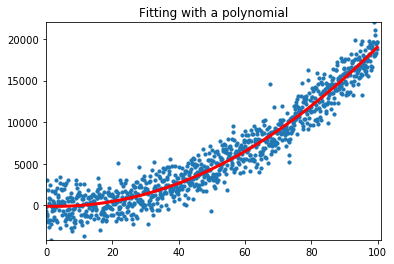

In [20]:
# To graph curves, you need to create a fine-mesh line plot:
y_parabola = m_w * x**2 + m_x * x + b

# Create a Figure and subplot objects
fig = plt.figure()
polydata_graph = fig.add_subplot(1,1,1)

# Plot the data and the best fit line
polydata_graph.scatter(x, y_p, s=10)
polydata_graph.axis([0,101,y_p.min(),y_p.max()])
polydata_graph.plot(x, y_parabola, c='r', linewidth=3)
polydata_graph.set_title("Fitting with a polynomial")

plt.show()

You might want to ask: "where did you get that equation, $m_w x^2 + m_x x + b = y$?"  The answer lies in figuring out what is meant mathematically by the statment: "_remember_ that $w$ is really just $x^2$".  There's an equation we have that performs this "remembering":  it's the equation of the surface 
$$x^2 = w$$
The actual equation we get is the one that comes from creating a __system of equations__:
\begin{align}
w &= x^2, \\
y &= m_w w + m_x x + b 
\end{align}

This surface appears as follows in $xwy$-space, the parabola we fit is the bright red spacecurve in the figure, projected to the $xy$-axis.

In [21]:
# First: generate a mesh for the surface
x_s = np.arange(0, 100, 1)                
y_s = np.arange(y_p.min(), y_p.max(), (y_p.max() - y_p.min())/1000)
x_s, y_s = np.meshgrid(x_s, y_s)

w_s = x_s**2

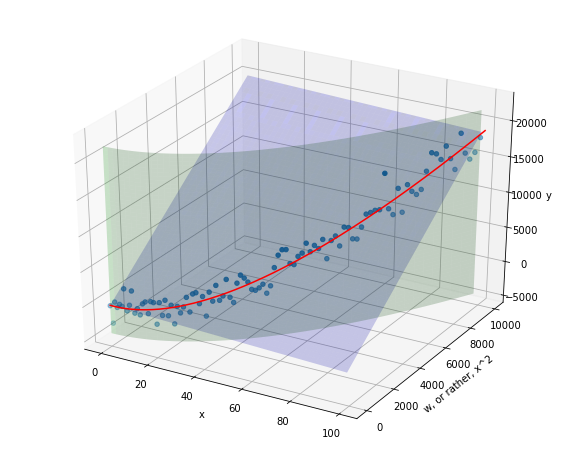

In [23]:
fig = plt.figure(figsize=(10,8))
scatter_3d = fig.add_subplot(1,1,1, projection='3d')

scatter_3d.set_xlabel('x')
scatter_3d.set_ylabel('w, or rather, x^2')
scatter_3d.set_zlabel('y')

# Plot the data
scatter_3d.scatter(down_df['x'], down_df['w (or rather, x^2)'], down_y_p)

# Plot the plane and surface
scatter_3d.plot_surface(x_plane, w_plane, y_plane, color='b', alpha=.2)
scatter_3d.plot_surface(x_s, w_s, y_s, color='g', alpha=.2)

# Plot the line of intersection 
scatter_3d.plot(x, x**2, y_parabola, color='r')

plt.show()

The last thing you always want to do when you create a model is to graph the residuals:

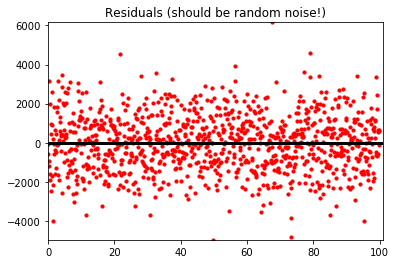

In [24]:
# Create residuals array
fig = plt.figure()
residuals = fig.add_subplot(1,1,1)

resid = y_p - np.array([m_w* i**2 + m_x * i + b  for i in x])

# Plot the residuals
residuals.scatter(x, resid, c='r', s=10)
residuals.plot([0,101],[0,0], c='k', linewidth=3)
residuals.set_title("Residuals (should be random noise!)")
residuals.autoscale(tight=True)

Sweet, sweet randomness. 

#### Side note: the Student's t-Test

You may be wondering if there is a way to get some hard numbers around this idea of "Are my residuals actually random?"  The answer is yes, absolutely.  That's one of the main points of Statistics!  The one you're looking for is called the [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test).

### Polynomial Logistic Regression

Just to see what it might look like, let's consider a case where we might need polynomial logistic regression.

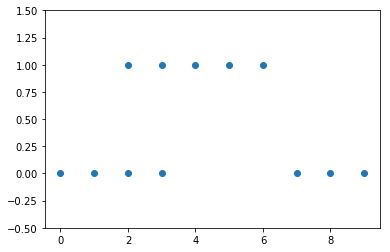

In [40]:
x = [0,1,2,2,3,3,4,5,6,7,8,9]
y = [0,0,1,0,1,0,1,1,1,0,0,0]

plt.scatter(x, y)
plt.ylim([-0.5, 1.5])
plt.show()

What we see here is the data has 0's on the outside $x$-values and 1's on the inner $x$-values.  This turning around behavior sounds like the job of a parabola!

In [41]:
# Let's make a DataFrame with an extra column
df = pd.DataFrame({'x':x, 'x^2':np.array(x)**2})
df.head()

,x,x^2
0,0,0
1,1,1
2,2,4
3,2,4
4,3,9


[array([ 0.97487252]), array([ 5.82670067])]


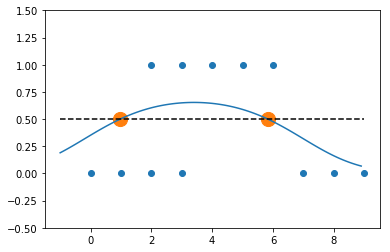

In [52]:
model = LogisticRegression().fit(df.values, y)
m_1, m_2 = model.coef_[0]
b = model.intercept_

x_curve = np.arange(-1, 9, 0.1)
y_curve = 1 / (1+ np.exp(-m_1 * x_curve - m_2 * x_curve**2 - b))

# Quadratic formula, since the 0.5 points are exactly when the exponent in the denomenator is 0
cutoffs = [(-m_1 + np.sqrt(m_1**2 - 4 * m_2 * b)) / (2 * m_2), (-m_1 - np.sqrt(m_1**2 - 4 * m_2 * b)) / (2 * m_2)]
print(cutoffs)

plt.scatter(x, y)
plt.plot(x_curve, y_curve)
plt.plot([-1, 9], [0.5, 0.5], 'k--')
plt.scatter(cutoffs, [0.5, 0.5], s=200)
plt.ylim([-0.5, 1.5])
plt.show()

This seems like a reasonable curve, and will have two decision-changing points at roughly $x=1$ and $x=5.8$.